In [87]:
studentsScriptFileName = "Actual Test Scripts (after override).xlsx"
standAnswerFileName = "Actual Test Solution_override.xlsx"

In [88]:
!pip install numpy pandas openpyxl seaborn matplotlib scipy Jinja2 shapely

In [89]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as spc
from scipy import stats
import os

In [90]:
df_script = pd.read_excel(
    os.path.join(os.getcwd(), "data", studentsScriptFileName), sheet_name=None
)
df_answer = pd.read_excel(
    os.path.join(os.getcwd(), "data", standAnswerFileName), sheet_name=None
)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [91]:
df_answer["DocumentValue"].head()
df_answer["DocumentValue"].columns

Index(['Q1', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14-No', 'Q14-Yes', 'Q15-No',
       'Q15-Yes', 'Q16', 'Q17', 'Q18-No', 'Q18-Yes', 'Q19-No', 'Q19-Yes', 'Q2',
       'Q20', 'Q21-No', 'Q21-Yes', 'Q22-No', 'Q22-Yes', 'Q23', 'Q24-No',
       'Q24-Yes', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q3', 'Q30-No', 'Q30-Yes',
       'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q4', 'Q45-No', 'Q45-Yes', 'Q46-No',
       'Q46-Yes', 'Q47-No', 'Q47-Yes', 'Q48-No', 'Q48-Yes', 'Q49-No',
       'Q49-Yes', 'Q5', 'Q56', 'Q57-No', 'Q57-Yes', 'Q58', 'Q59',
       'Q6 resource', 'Q60', 'Q62', 'Q65', 'Q66', 'Q67', 'Q68', 'Q69', 'Q7',
       'Q70', 'Q8', 'Q9', 'Q36', 'Q38', 'Q40', 'Q50:', 'Q63'],
      dtype='object')

Columns appear in Standard answer but not in Student script, whihc is missing from Amazon Textract and probably because all students do not answer those question!

In [92]:
df_answer["DocumentValue"].columns.difference(df_script["PageAnswerGeometry"].columns)

Index(['Q29', 'Q56', 'Q58', 'Q59', 'Q6 resource', 'Q60', 'Q62', 'Q69', 'Q7',
       'Q9'],
      dtype='object')

Columns appear in student script but not in Standard answer, and you need to updated the answer excel.

In [93]:
df_script["PageAnswerGeometry"].columns.difference(df_answer["DocumentValue"].columns)

Index(['233', '5.14 SMIB', 'Azure', 'Class', 'Class1', 'IC Q17', 'ID', 'ID1',
       'Name', 'Name 1', 'Name: 1', 'Q2 INto', 'Q2 resore Broup Q3',
       'Q7 system tools Q8', 'Resource Q2 Q3', 'Virtual Machine Q3', 'go',
       'las Q17', 'level', 'tempalary'],
      dtype='object')

Common columns

In [94]:
columns = (
    df_script["PageAnswerGeometry"]
    .columns.intersection(df_answer["DocumentValue"].columns)
    .to_list()
)
columns

['Q1',
 'Q10',
 'Q11',
 'Q12',
 'Q13',
 'Q14-No',
 'Q14-Yes',
 'Q15-No',
 'Q15-Yes',
 'Q16',
 'Q17',
 'Q18-No',
 'Q18-Yes',
 'Q19-No',
 'Q19-Yes',
 'Q2',
 'Q20',
 'Q21-No',
 'Q21-Yes',
 'Q22-No',
 'Q22-Yes',
 'Q23',
 'Q24-No',
 'Q24-Yes',
 'Q25',
 'Q26',
 'Q27',
 'Q28',
 'Q3',
 'Q30-No',
 'Q30-Yes',
 'Q31',
 'Q32',
 'Q33',
 'Q34',
 'Q35',
 'Q36',
 'Q38',
 'Q4',
 'Q40',
 'Q45-No',
 'Q45-Yes',
 'Q46-No',
 'Q46-Yes',
 'Q47-No',
 'Q47-Yes',
 'Q48-No',
 'Q48-Yes',
 'Q49-No',
 'Q49-Yes',
 'Q5',
 'Q50:',
 'Q57-No',
 'Q57-Yes',
 'Q63',
 'Q65',
 'Q66',
 'Q67',
 'Q68',
 'Q70',
 'Q8']

Apppend Student Name and ID columns

In [95]:
columns.insert(0, "Name")
columns.insert(0, "ID")
columns

['ID',
 'Name',
 'Q1',
 'Q10',
 'Q11',
 'Q12',
 'Q13',
 'Q14-No',
 'Q14-Yes',
 'Q15-No',
 'Q15-Yes',
 'Q16',
 'Q17',
 'Q18-No',
 'Q18-Yes',
 'Q19-No',
 'Q19-Yes',
 'Q2',
 'Q20',
 'Q21-No',
 'Q21-Yes',
 'Q22-No',
 'Q22-Yes',
 'Q23',
 'Q24-No',
 'Q24-Yes',
 'Q25',
 'Q26',
 'Q27',
 'Q28',
 'Q3',
 'Q30-No',
 'Q30-Yes',
 'Q31',
 'Q32',
 'Q33',
 'Q34',
 'Q35',
 'Q36',
 'Q38',
 'Q4',
 'Q40',
 'Q45-No',
 'Q45-Yes',
 'Q46-No',
 'Q46-Yes',
 'Q47-No',
 'Q47-Yes',
 'Q48-No',
 'Q48-Yes',
 'Q49-No',
 'Q49-Yes',
 'Q5',
 'Q50:',
 'Q57-No',
 'Q57-Yes',
 'Q63',
 'Q65',
 'Q66',
 'Q67',
 'Q68',
 'Q70',
 'Q8']

Remove columns do not show in answer

In [96]:
for key in df_answer.keys():
    df_script[key] = df_script[key][columns]
df_answer.keys()

dict_keys(['DocumentValue', 'DocumentConfidence', 'DocumentAnswerSimilarity', 'DocumentAnswerGeometry', 'DocumentAnswerImage', 'PageValue', 'PageConfidence', 'PageAnswerSimilarity', 'PageAnswerGeometry', 'PageAnswerImage'])

# Preprocessing boundbox with margin.

In [97]:
import os
from urllib.parse import urlparse
import urllib.request
from pathlib import Path
import urllib.request


path = Path(os.path.join(os.getcwd(), "output", "grading_form", "images"))
path.mkdir(parents=True, exist_ok=True)
images = {}
for rowIndex, row in df_script["DocumentAnswerImage"].iterrows():  # iterate over rows
    for columnIndex, value in row.items():
        if not pd.isna(value) and value not in images:
            url = urlparse(value)
            fileName = os.path.basename(url.path)
            fileName = os.path.join("output", "grading_form", "images", fileName)
            if not os.path.isfile(fileName):
                urllib.request.urlretrieve(value, fileName)
            images[value] = fileName

In [98]:
from PIL import Image

dir_path = Path(os.path.join(os.getcwd(), "output", "grading_form", "images"))


def mapper(x):
    if pd.isna(x) or x is None:
        return None
    j = json.loads(x)
    if j is None:
        return None
    if "BoundingBox" in j:
        if "page" in j:
            boundingBox = j["BoundingBox"]
            path = Path(os.path.join(dir_path, "p-" + str(j["page"]) + ".png"))
            with Image.open(path) as im:
                # The crop method from the Image module takes four coordinates as input.
                # The right can also be represented as (left+width)
                # and lower can be represented as (upper+height).
                pageWidth, pageHeight = im.size
                boundingBox["page"] = j["page"] + 1
                width, height = im.size

                margin = boundingBox["Height"] * 0.05
                leftMargin = margin + 50
                (left, top, width, height) = (
                    max(pageWidth * boundingBox["Left"] - leftMargin, 0),
                    max(pageHeight * boundingBox["Top"] - margin, 0),
                    min(
                        pageWidth * boundingBox["Width"] + leftMargin + margin,
                        pageWidth,
                    ),
                    min(pageHeight * boundingBox["Height"] + 2 * margin, pageHeight),
                )
                return {
                    "left": left,
                    "top": top,
                    "height": height,
                    "width": width,
                    "page": j["page"],
                }
        try:
            return json.loads(j)["BoundingBox"]
        except:
            print(type(j))


df_script["DocumentBoundingBox"] = df_script["DocumentAnswerGeometry"].applymap(mapper)
df_answer["DocumentBoundingBox"] = df_answer["DocumentAnswerGeometry"].applymap(mapper)

# Preparation for the imputation the missing page

In [99]:
def mapper(x):
    if pd.isna(x) or x is None:
        return 0
    else:
        return 1


df_script["PageAnswer"] = df_script["PageAnswerGeometry"].applymap(mapper)
df_script["PageAnswer"].head()

,ID,Name,Q1,Q10,Q11,Q12,Q13,Q14-No,Q14-Yes,Q15-No,...,Q50:,Q57-No,Q57-Yes,Q63,Q65,Q66,Q67,Q68,Q70,Q8
0,0,0,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
1,1,1,0,0,0,0,0,0,0,0,...,1,1,1,0,0,1,1,0,1,0
2,0,0,0,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
3,1,1,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
4,0,0,0,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1


Create correlation matrix and apply clustering.

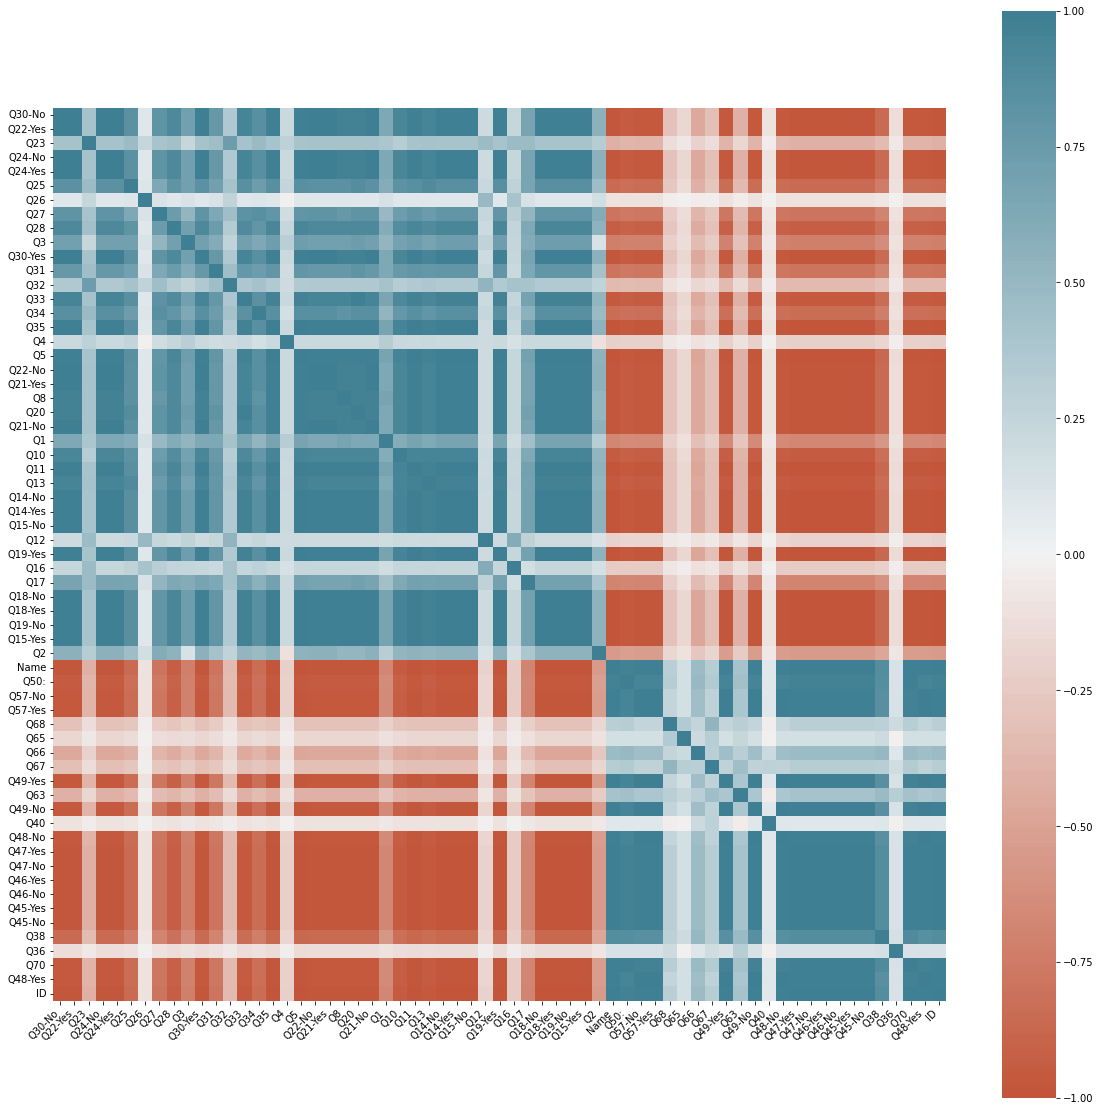

In [100]:
import scipy
import scipy.cluster.hierarchy as sch


def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly
    correlated variables are next to eachother

    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix

    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method="complete")
    cluster_distance_threshold = pairwise_distances.max() / 2
    idx_to_cluster_array = sch.fcluster(
        linkage, cluster_distance_threshold, criterion="distance"
    )
    idx = np.argsort(idx_to_cluster_array)

    if not inplace:
        corr_array = corr_array.copy()

    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]


corr = df_script["PageAnswer"].corr(method="pearson")
corr = cluster_corr(corr)
fig, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(
    corr,
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right");

A Page contains a set of question and it is a group.

In [101]:
pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method="complete")
idx = spc.fcluster(linkage, 0.5 * pdist.max(), "distance")

grouping = pd.DataFrame(data={"question": corr.columns, "group": idx})
grouping

,question,group
0,Q30-No,1
1,Q22-Yes,1
2,Q23,1
3,Q24-No,1
4,Q24-Yes,1
...,...,...
58,Q38,2
59,Q36,2
60,Q70,2
61,Q48-Yes,2


In [102]:
question_group = (
    grouping.groupby("group")["question"].apply(list).reset_index(name="questions")
)
question_group

,group,questions
0,1,"[Q30-No, Q22-Yes, Q23, Q24-No, Q24-Yes, Q25, Q..."
1,2,"[Name, Q50:, Q57-No, Q57-Yes, Q68, Q65, Q66, Q..."


Create ignore flag if the average of correlation is less than 0.5. Because Amazon Textract may capture some noise questions and it will become a group, the noise group correlation is very low.

In [103]:
def get_subgroup_average(questions, corr):
    subdf = corr[questions]
    return subdf[subdf.index.isin(questions)].mean().mean()


question_group["mean"] = question_group["questions"].apply(
    lambda x: get_subgroup_average(x, corr)
)
question_group["ignore"] = question_group["mean"] < 0.5
question_group

,group,questions,mean,ignore
0,1,"[Q30-No, Q22-Yes, Q23, Q24-No, Q24-Yes, Q25, Q...",0.695542,False
1,2,"[Name, Q50:, Q57-No, Q57-Yes, Q68, Q65, Q66, Q...",0.625797,False


In [104]:
question_mapping = pd.merge(grouping, question_group, how="inner", on="group").rename(
    columns={"questions": "question_set"}
)
question_mapping = question_mapping.set_index("question")
question_mapping

,group,question_set,mean,ignore
question,,,,
Q30-No,1,"[Q30-No, Q22-Yes, Q23, Q24-No, Q24-Yes, Q25, Q...",0.695542,False
Q22-Yes,1,"[Q30-No, Q22-Yes, Q23, Q24-No, Q24-Yes, Q25, Q...",0.695542,False
Q23,1,"[Q30-No, Q22-Yes, Q23, Q24-No, Q24-Yes, Q25, Q...",0.695542,False
Q24-No,1,"[Q30-No, Q22-Yes, Q23, Q24-No, Q24-Yes, Q25, Q...",0.695542,False
Q24-Yes,1,"[Q30-No, Q22-Yes, Q23, Q24-No, Q24-Yes, Q25, Q...",0.695542,False
...,...,...,...,...
Q38,2,"[Name, Q50:, Q57-No, Q57-Yes, Q68, Q65, Q66, Q...",0.625797,False
Q36,2,"[Name, Q50:, Q57-No, Q57-Yes, Q68, Q65, Q66, Q...",0.625797,False
Q70,2,"[Name, Q50:, Q57-No, Q57-Yes, Q68, Q65, Q66, Q...",0.625797,False


By checking question_set, we can impute the missing page number by checking the page in the same set.

# Preparation for the imputation the missing bounding box

Exclude the ignore columns and calculates the ratio of missing value for each question.

In [105]:
columns = question_mapping[question_mapping["ignore"] == False].index
df_script["DocumentBoundingBoxFiltered"] = df_script["DocumentBoundingBox"][columns]
df_script["DocumentBoundingBoxFiltered"].isna().mean().round(4) * 100

Q30-No      1.75
Q22-Yes     1.75
Q23        71.93
Q24-No      1.75
Q24-Yes     1.75
           ...  
Q38        14.04
Q36        96.49
Q70         1.75
Q48-Yes     1.75
ID          0.00
Length: 63, dtype: float64

In [106]:
def get_trim_mean(box, field):
    return stats.trim_mean(list(map(lambda x: x[field], box)), 0.05)


def trimed_mean_bound_box(boxes):
    box = list(filter(lambda box: box is not None, boxes))
    height = get_trim_mean(box, "height")
    left = get_trim_mean(box, "left")
    top = get_trim_mean(box, "top")
    width = get_trim_mean(box, "width")

    return {"height": height, "left": left, "top": top, "width": width}


trimedMeanBoundBoxes = df_script["DocumentBoundingBoxFiltered"].agg(
    trimed_mean_bound_box, axis=0
)
frame = {"boundingBox": trimedMeanBoundBoxes}
estimatedBoundBoxes = pd.DataFrame(frame)
estimatedBoundBoxes.head()

,boundingBox
Q30-No,"{'height': 102.4484228174184, 'left': 3508.050..."
Q22-Yes,"{'height': 100.90692043213821, 'left': 2988.05..."
Q23,"{'height': 276.3572833928978, 'left': 669.3747..."
Q24-No,"{'height': 102.3609463311105, 'left': 3509.589..."
Q24-Yes,"{'height': 101.48595044755808, 'left': 2987.00..."


# Imputation for the missing Bounding box

In [107]:
df_script["DocumentBoundingBoxImpute"] = df_script["DocumentBoundingBox"].copy()

In [108]:
from statistics import mode


def impute_page_and_boundbox(df, row_number, row):
    for key, cell in row.items():
        if cell is None:
            estimatedBoundBox = estimatedBoundBoxes.loc[[key]]["boundingBox"][0]
            questionSet = question_mapping.loc[[key]]["question_set"][0]
            page = mode(
                map(
                    lambda x: x["page"],
                    filter(lambda x: x is not None, map(lambda q: row[q], questionSet)),
                )
            )
            estimatedBoundBox = {
                "left": estimatedBoundBox["left"],
                "top": estimatedBoundBox["top"],
                "height": estimatedBoundBox["height"],
                "width": estimatedBoundBox["width"],
                "page": page,
            }
            df.at[row_number, key] = estimatedBoundBox


for i, j in df_script["DocumentBoundingBox"].iterrows():
    impute_page_and_boundbox(df_script["DocumentBoundingBoxImpute"], i, j)
df_script["DocumentBoundingBoxImpute"].head()

,ID,Name,Q1,Q10,Q11,Q12,Q13,Q14-No,Q14-Yes,Q15-No,...,Q50:,Q57-No,Q57-Yes,Q63,Q65,Q66,Q67,Q68,Q70,Q8
0,"{'left': 823.9027038900182, 'top': 960.2456718...","{'left': 893.0692315155641, 'top': 589.0973582...","{'left': 444.6220102198422, 'top': 1078.070501...","{'left': 1482.4444069264457, 'top': 2538.08218...","{'left': 3487.4613205963747, 'top': 2542.46065...","{'left': 513.5366480177269, 'top': 2888.436013...","{'left': 2324.907082133554, 'top': 2905.207050...","{'left': 1259.0419328053947, 'top': 5630.26112...","{'left': 734.1133736902848, 'top': 5628.660752...","{'left': 1257.217829889944, 'top': 5783.833003...",...,"{'left': 3338.6502259938047, 'top': 2690.48311...","{'left': 3573.200520595303, 'top': 6036.137656...","{'left': 3053.2483123840298, 'top': 6030.19859...","{'left': 3546.450780797684, 'top': 4088.472427...","{'left': 2096.6294662560335, 'top': 4470.26584...","{'left': 3550.2638235950844, 'top': 4463.69445...","{'left': 627.4503261795268, 'top': 4825.427331...","{'left': 2084.558112325026, 'top': 4875.328597...","{'left': 565.5899226335808, 'top': 5171.420025...","{'left': 2232.127945062332, 'top': 2174.764624..."
1,"{'left': 684.895612794999, 'top': 948.03695004...","{'left': 770.6556259077042, 'top': 555.5667571...","{'left': 489.46929912663944, 'top': 1088.36926...","{'left': 1493.9150880951433, 'top': 2530.95277...","{'left': 3500.808199974522, 'top': 2537.298319...","{'left': 513.5366480177269, 'top': 2888.436013...","{'left': 2324.9402597147973, 'top': 2896.47468...","{'left': 1275.9714347300119, 'top': 5630.34351...","{'left': 750.0905675122515, 'top': 5630.111074...","{'left': 1272.4719558634329, 'top': 5784.56591...",...,"{'left': 3349.0849856628106, 'top': 2663.52194...","{'left': 3560.4984368418345, 'top': 6034.99847...","{'left': 3044.3368995432743, 'top': 6030.93693...","{'left': 3632.2879639903085, 'top': 4170.73680...","{'left': 2060.508864280209, 'top': 4468.392118...","{'left': 3599.5457994710655, 'top': 4478.23316...","{'left': 605.0846594220027, 'top': 4869.118226...","{'left': 2059.218998424802, 'top': 4905.986548...","{'left': 654.0838392861187, 'top': 5182.513298...","{'left': 2239.2170795969664, 'top': 2132.70846..."
2,"{'left': 618.7491756749339, 'top': 954.8694077...","{'left': 726.8871150016785, 'top': 580.7760912...","{'left': 489.46929912663944, 'top': 1088.36926...","{'left': 1469.2194587824865, 'top': 2525.51803...","{'left': 3479.0450052866713, 'top': 2519.45561...","{'left': 513.5366480177269, 'top': 2888.436013...","{'left': 2347.1398888463154, 'top': 2906.24953...","{'left': 1250.1414197458885, 'top': 5612.25539...","{'left': 725.27060888852, 'top': 5614.16388271...","{'left': 1249.910087740561, 'top': 5770.183128...",...,"{'left': 3246.7672354787587, 'top': 2615.28776...","{'left': 3560.9734715576283, 'top': 6022.45306...","{'left': 3041.79733042093, 'top': 6021.0312229...","{'left': 3527.701726801507, 'top': 4070.327188...","{'left': 2096.6294662560335, 'top': 4470.26584...","{'left': 3532.690424905345, 'top': 4447.681217...","{'left': 589.0851177968085, 'top': 4873.885247...","{'left': 2120.015958631877, 'top': 4860.890892...","{'left': 558.885252331011, 'top': 5149.4463307...","{'left': 2214.2842764491215, 'top': 2127.96807..."
3,"{'left': 617.856411109399, 'top': 988.23378757...","{'left': 709.1612284813076, 'top': 610.0030448...","{'left': 449.13419540561733, 'top': 1085.37182...","{'left': 1479.1275802800433, 'top': 2534.93205...","{'left': 3504.729877394624, 'top': 2549.412671...","{'left': 513.5366480177269, 'top': 2888.436013...","{'left': 2330.7477844782175, 'top': 2923.96795...","{'left': 1276.5413598805667, 'top': 5636.08726...","{'left': 748.9032446485013, 'top': 5639.658433...","{'left': 1275.0109557256103, 'top': 5790.47937...",...,"{'left': 3386.939660468511, 'top': 2713.049635...","{'left': 3560.5184553069994, 'top': 6031.17850...","{'left': 3036.8223247528076, 'top': 6030.96575...","{'left': 3540.630915618874, 'top': 4082.373377...","{'left': 2096.629466256033

# Imputation Image path

In [109]:
df_script["DocumentAnswerImageLocal"] = df_script["DocumentAnswerImage"]
df_script["DocumentAnswerImageLocal"] = df_script["DocumentAnswerImageLocal"].applymap(
    lambda x: images[x], na_action="ignore"
)

df_script["DocumentAnswerImageLocal"].head()

,ID,Name,Q1,Q10,Q11,Q12,Q13,Q14-No,Q14-Yes,Q15-No,...,Q50:,Q57-No,Q57-Yes,Q63,Q65,Q66,Q67,Q68,Q70,Q8
0,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,output/grading_form/images/p-1.png,output/grading_form/images/p-1.png,output/grading_form/images/p-1.png,NaN,output/grading_form/images/p-1.png,output/grading_form/images/p-1.png,output/grading_form/images/p-1.png,output/grading_form/images/p-1.png,...,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,NaN,NaN,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,NaN,output/grading_form/images/p-2.png,output/grading_form/images/p-1.png
1,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,NaN,output/grading_form/images/p-3.png,output/grading_form/images/p-3.png,NaN,output/grading_form/images/p-3.png,output/grading_form/images/p-3.png,output/grading_form/images/p-3.png,output/grading_form/images/p-3.png,...,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-3.png
2,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,NaN,output/grading_form/images/p-5.png,output/grading_form/images/p-5.png,NaN,output/grading_form/images/p-5.png,output/grading_form/images/p-5.png,output/grading_form/images/p-5.png,output/grading_form/images/p-5.png,...,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,NaN,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-5.png
3,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,output/grading_form/images/p-7.png,output/grading_form/images/p-7.png,output/grading_form/images/p-7.png,NaN,output/grading_form/images/p-7.png,output/grading_form/images/p-7.png,output/grading_form/images/p-7.png,output/grading_form/images/p-7.png,...,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,NaN,NaN,NaN,NaN,output/grading_form/images/p-8.png,output/grading_form/images/p-7.png
4,output/grading_form/images/p-10.png,output/grading_form/images/p-10.png,NaN,output/grading_form/images/p-9.png,output/grading_form/images/p-9.png,NaN,output/grading_form/images/p-9.png,output/grading_form/images/p-9.png,output/grading_form/images/p-9.png,output/grading_form/images/p-9.png,...,output/grading_form/images/p-10.png,output/grading_form/images/p-10.png,output/grading_form/images/p-10.png,NaN,NaN,NaN,NaN,NaN,output/grading_form/images/p-10.png,output/grading_form/images/p-9.png


In [110]:
import math

path = Path(os.path.join(os.getcwd(), "output", "grading_form", "images"))


def impute_image_path(df, row_number, row):
    for key, cell in row.items():
        if cell is None:
            questionSet = question_mapping.loc[[key]]["question_set"][0]
            page = mode(
                map(
                    lambda x: x["page"],
                    filter(lambda x: x is not None, map(lambda q: row[q], questionSet)),
                )
            )
            df.at[row_number, key] = os.path.join(
                "output", "grading_form", "images", "p-" + str(page) + ".png"
            )


for i, j in df_script["DocumentBoundingBox"].iterrows():
    impute_image_path(df_script["DocumentAnswerImageLocal"], i, j)
df_script["DocumentAnswerImageLocal"].head()

,ID,Name,Q1,Q10,Q11,Q12,Q13,Q14-No,Q14-Yes,Q15-No,...,Q50:,Q57-No,Q57-Yes,Q63,Q65,Q66,Q67,Q68,Q70,Q8
0,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,output/grading_form/images/p-1.png,output/grading_form/images/p-1.png,output/grading_form/images/p-1.png,output/grading_form/images/p-1.png,output/grading_form/images/p-1.png,output/grading_form/images/p-1.png,output/grading_form/images/p-1.png,output/grading_form/images/p-1.png,...,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,output/grading_form/images/p-1.png
1,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-3.png,output/grading_form/images/p-3.png,output/grading_form/images/p-3.png,output/grading_form/images/p-3.png,output/grading_form/images/p-3.png,output/grading_form/images/p-3.png,output/grading_form/images/p-3.png,output/grading_form/images/p-3.png,...,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-3.png
2,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-5.png,output/grading_form/images/p-5.png,output/grading_form/images/p-5.png,output/grading_form/images/p-5.png,output/grading_form/images/p-5.png,output/grading_form/images/p-5.png,output/grading_form/images/p-5.png,output/grading_form/images/p-5.png,...,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-5.png
3,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,output/grading_form/images/p-7.png,output/grading_form/images/p-7.png,output/grading_form/images/p-7.png,output/grading_form/images/p-7.png,output/grading_form/images/p-7.png,output/grading_form/images/p-7.png,output/grading_form/images/p-7.png,output/grading_form/images/p-7.png,...,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,output/grading_form/images/p-7.png
4,output/grading_form/images/p-10.png,output/grading_form/images/p-10.png,output/grading_form/images/p-9.png,output/grading_form/images/p-9.png,output/grading_form/images/p-9.png,output/grading_form/images/p-9.png,output/grading_form/images/p-9.png,output/grading_form/images/p-9.png,output/grading_form/images/p-9.png,output/grading_form/images/p-9.png,...,output/grading_form/images/p-10.png,output/grading_form/images/p-10.png,output/grading_form/images/p-10.png,output/grading_form/images/p-10.png,output/grading_form/images/p-10.png,output/grading_form/images/p-10.png,output/grading_form/images/p-10.png,output/grading_form/images/p-10.png,output/grading_form/images/p-10.png,output/grading_form/images/p-9.png


# Preprocessing Choice style questions

In [111]:
estimatedBoundBoxesOptions = estimatedBoundBoxes[
    estimatedBoundBoxes.index.str.endswith("-Yes")
    | estimatedBoundBoxes.index.str.endswith("-No")
    | estimatedBoundBoxes.index.str.endswith("-A")
    | estimatedBoundBoxes.index.str.endswith("-B")
    | estimatedBoundBoxes.index.str.endswith("-C")
    | estimatedBoundBoxes.index.str.endswith("-D")
    | estimatedBoundBoxes.index.str.endswith("-E")
].copy()
estimatedBoundBoxesOptions["question"] = estimatedBoundBoxesOptions.index
estimatedBoundBoxesOptions[["question", "option"]] = estimatedBoundBoxesOptions[
    "question"
].str.split("-", 1, expand=True)
estimatedBoundBoxesOptions.head()

,boundingBox,question,option
Q30-No,"{'height': 102.4484228174184, 'left': 3508.050...",Q30,No
Q22-Yes,"{'height': 100.90692043213821, 'left': 2988.05...",Q22,Yes
Q24-No,"{'height': 102.3609463311105, 'left': 3509.589...",Q24,No
Q24-Yes,"{'height': 101.48595044755808, 'left': 2987.00...",Q24,Yes
Q30-Yes,"{'height': 102.40561179672908, 'left': 2985.78...",Q30,Yes


In [112]:
from shapely import geometry
from functools import reduce


def to_polygon(boundingbox):
    p1 = geometry.Point(boundingbox["left"], boundingbox["top"])
    p2 = geometry.Point(boundingbox["left"] + boundingbox["width"], boundingbox["top"])
    p3 = geometry.Point(boundingbox["left"], boundingbox["top"] + boundingbox["height"])
    p4 = geometry.Point(
        boundingbox["left"] + boundingbox["width"],
        boundingbox["top"] + boundingbox["height"],
    )
    pointList = [p1, p2, p3, p4, p1]
    return geometry.Polygon(pointList)


def to_combined_boundingbox(boundingboxes):
    combined = reduce(
        lambda x, y: x.union(y), map(lambda b: to_polygon(b), boundingboxes)
    )
    x_min = combined.bounds[0]
    y_min = combined.bounds[1]
    x_max = combined.bounds[2]
    y_max = combined.bounds[3]

    boundingbox = {
        "left": x_min,
        "top": y_min,
        "width": x_max - x_min,
        "height": y_max - y_min,
    }
    return boundingbox


questionOptions = estimatedBoundBoxesOptions["question"].to_list()
groupedOptions = estimatedBoundBoxesOptions.groupby(["question"]).apply(dict).to_dict()

combined_boundingbox = dict(
    map(
        lambda q: (q, to_combined_boundingbox(groupedOptions[q]["boundingBox"])),
        groupedOptions,
    )
)

In [113]:
import math

estimatedOptions = pd.DataFrame(
    combined_boundingbox.items(), columns=["question", "boundingBox"]
).set_index("question")
questionToAnswer = df_answer["DocumentValue"].iloc[0].to_dict()
for key, value in questionToAnswer.items():
    # do something with value
    questionToAnswer[key] = value if type(value) is str else ""

choices = ["Yes", "No", "A", "B", "C", "D", "E"]


def get_answer(row):
    queston = row.name
    return set(
        filter(
            lambda x: x != "",
            map(
                lambda x: x
                if queston + "-" + x in questionToAnswer
                and questionToAnswer[queston + "-" + x] == "X"
                else "",
                choices,
            ),
        )
    )


def get_choices(row):
    queston = row.name
    return list(
        filter(
            lambda x: x != "",
            map(
                lambda x: queston + "-" + x
                if queston + "-" + x in questionToAnswer
                else "",
                choices,
            ),
        )
    )


estimatedOptions["answers"] = estimatedOptions.apply(get_answer, axis=1)
estimatedOptions["choices"] = estimatedOptions.apply(get_choices, axis=1)
estimatedOptions

,boundingBox,answers,choices
question,,,
Q14,"{'left': 747.343038871372, 'top': 5622.0426138...",{No},"[Q14-Yes, Q14-No]"
Q15,"{'left': 745.1395789779767, 'top': 5778.346653...",{Yes},"[Q15-Yes, Q15-No]"
Q18,"{'left': 743.7858445982413, 'top': 5933.787396...",{No},"[Q18-Yes, Q18-No]"
Q19,"{'left': 741.4292268433213, 'top': 6089.049383...",{Yes},"[Q19-Yes, Q19-No]"
Q21,"{'left': 2989.785737098847, 'top': 5620.365251...",{No},"[Q21-Yes, Q21-No]"
Q22,"{'left': 2988.052844447189, 'top': 5775.647148...",{Yes},"[Q22-Yes, Q22-No]"
Q24,"{'left': 2987.0048408757552, 'top': 5931.49719...",{No},"[Q24-Yes, Q24-No]"
Q30,"{'left': 2985.7808490820294, 'top': 6087.65460...",{No},"[Q30-Yes, Q30-No]"
Q45,"{'left': 812.6859405272254, 'top': 5691.206684...",{No},"[Q45-Yes, Q45-No]"


In [114]:
questionToAnswer

{'Q1': 'account',
 'Q10': 'security principal',
 'Q11': 'assignment',
 'Q12': 'role definition',
 'Q13': 'grant access to others',
 'Q14-No': 'X',
 'Q14-Yes': '',
 'Q15-No': '',
 'Q15-Yes': 'X',
 'Q16': 'ARM',
 'Q17': 'deny all',
 'Q18-No': 'X',
 'Q18-Yes': '',
 'Q19-No': '',
 'Q19-Yes': 'X',
 'Q2': 'Azure AD account',
 'Q20': 'application rules',
 'Q21-No': 'X',
 'Q21-Yes': '',
 'Q22-No': '',
 'Q22-Yes': 'X',
 'Q23': 'services Endpoint',
 'Q24-No': 'X',
 'Q24-Yes': '',
 'Q25': 'health Probes',
 'Q26': 'RA-GZRS',
 'Q27': 'page blobs',
 'Q28': 'SAS',
 'Q29': 'Azure Files',
 'Q3': 'tenant',
 'Q30-No': 'X',
 'Q30-Yes': '',
 'Q31': 'autoscale',
 'Q32': 'desired state configuration',
 'Q33': 'deployment Slots',
 'Q34': 'load balancer',
 'Q35': 'Azure site recovery',
 'Q4': 'subscription',
 'Q45-No': 'X',
 'Q45-Yes': '',
 'Q46-No': 'X',
 'Q46-Yes': '',
 'Q47-No': '',
 'Q47-Yes': 'X',
 'Q48-No': '',
 'Q48-Yes': 'X',
 'Q49-No': 'X',
 'Q49-Yes': '',
 'Q5': 'regions are paired',
 'Q56': 'MFA',
 

# Generate Marking form

In [311]:
from distutils.dir_util import copy_tree

from_directory = os.path.join(os.getcwd(), "templates", "javascript")
to_directory = os.path.join(os.getcwd(), "output", "grading_form", "javascript")
copy_tree(from_directory, to_directory)

['/home/studio-lab-user/sagemaker-studiolab-notebooks/output/grading_form/javascript/.ipynb_checkpoints/common-checkpoint.js',
 '/home/studio-lab-user/sagemaker-studiolab-notebooks/output/grading_form/javascript/common.js']

In [312]:
from jinja2 import Template
from jinja2 import Environment, FileSystemLoader

file_loader = FileSystemLoader("templates")
env = Environment(loader=file_loader)
template = env.get_template("index.html")

questions = df_script["DocumentBoundingBox"].columns.to_list()


textAnswer = []
for question in questions:
    optionsDf = estimatedBoundBoxesOptions[
        estimatedBoundBoxesOptions.index.str.fullmatch(question)
    ]
    if optionsDf.empty:  # skip choice questions
        textAnswer.append(question)
optionAnswer = estimatedOptions.index.to_list()

questionOfMarks = textAnswer + optionAnswer

output = template.render(
    studentsScriptFileName=studentsScriptFileName,
    textAnswer=textAnswer,
    optionAnswer=optionAnswer,
)
# open text file
path = Path(os.path.join(os.getcwd(), "output", "grading_form", "questions"))
path.mkdir(parents=True, exist_ok=True)
path = Path(os.path.join(os.getcwd(), "output", "grading_form", "index.html"))
text_file = open(path, "w")
text_file.write(output)
text_file.close()

Generate grading form for text answer questions.

In [313]:
def extract_table(dataframeName, question, newName):
    tempTable = df_script[dataframeName].copy()
    tempTable = tempTable[[question]]
    tempTable.reset_index(inplace=True)
    tempTable["RowNumber"] = tempTable.index
    tempTable.rename(columns={question: newName}, inplace=True)
    return tempTable


def get_question_df(question):
    answerTable = extract_table("DocumentValue", question, "Answer")
    imageTable = extract_table("DocumentAnswerImageLocal", question, "Image")
    confidenceTable = extract_table("DocumentConfidence", question, "Confidence")
    similarityTable = extract_table("DocumentAnswerSimilarity", question, "Similarity")
    geometryTable = extract_table("DocumentBoundingBoxImpute", question, "BoundingBox")

    dataTable = pd.merge(
        answerTable, imageTable, on="RowNumber", suffixes=("", "_remove")
    )
    dataTable = pd.merge(
        dataTable, confidenceTable, on="RowNumber", suffixes=("", "_remove")
    )
    dataTable = pd.merge(
        dataTable, similarityTable, on="RowNumber", suffixes=("", "_remove")
    )
    dataTable = pd.merge(
        dataTable, geometryTable, on="RowNumber", suffixes=("", "_remove")
    )
    dataTable.drop(
        [i for i in dataTable.columns if "_remove" in i], axis=1, inplace=True
    )

    dataTable["Similarity"] = dataTable["Similarity"].fillna(0)
    dataTable["Answer"] = dataTable["Answer"].fillna("")
    dataTable["Image"] = dataTable["Image"].str.replace("output/grading_form/", "")

    dataTable = dataTable.sort_values(by=["Similarity"], ascending=False)
    return dataTable

def save_template_output(output, question, filename):
    path = Path(
        os.path.join(os.getcwd(), "output", "grading_form", "questions", question)
    )
    path.mkdir(parents=True, exist_ok=True)
    path = Path(
        os.path.join(
            os.getcwd(), "output", "grading_form", "questions", question, filename
        )
    )
    text_file = open(path, "w")
    text_file.write(output)
    text_file.close()

In [314]:
questions = df_script["DocumentBoundingBox"].columns.to_list()

for question in questions:
    optionsDf = estimatedBoundBoxesOptions[
        estimatedBoundBoxesOptions.index.str.fullmatch(question)
    ]
    if not optionsDf.empty:  # skip choice questions
        continue

    dataTable = get_question_df(question)

    standardAnswer = None
    estimatedBoundingBox = None
    if question in df_answer["DocumentValue"].columns:
        standardAnswer = questionToAnswer[question]
    if question in df_script["DocumentBoundingBox"].columns:
        estimatedBoundingBox = estimatedBoundBoxes.loc[[question]]["boundingBox"][0]

    if question == "ID" or question == "Name":
        template = env.get_template("questions/index-answer.html")
    else:
        template = env.get_template("questions/index.html")
    output = template.render(
        studentsScriptFileName=studentsScriptFileName,
        question=question,
        standardAnswer=standardAnswer,
        estimatedBoundingBox=estimatedBoundingBox,
        dataTable=dataTable,
    )
    save_template_output(output, question, "index.html")
    
    template = env.get_template("questions/question.js")
    output = template.render(
        dataTable=dataTable,
    )
    save_template_output(output, question, "question.js")

    template = env.get_template("questions/style.css")
    output = template.render(
        dataTable=dataTable,
    )
    save_template_output(output, question, "style.css")

Generate grading form for choices style questions.

In [306]:
for index, row in estimatedOptions.iterrows():
    question = index
    choices = row["choices"]
    estimatedBoundingBox = row["boundingBox"]
    answers = row["answers"]
    answersMask = list(
        map(lambda c: 1 if c.replace(question + "-", "") in answers else 0, choices)
    )
    choicesDf = list(map(lambda o: (o, get_question_df(o)), choices))

    rowNumber = choicesDf[0][1]["RowNumber"]
    images = choicesDf[0][1]["Image"]

    df = pd.DataFrame(
        list(zip(rowNumber, images)), columns=["RowNumber", "Image"], index=rowNumber
    )

    choiceDict = {}
    for index, item in enumerate(choicesDf):
        q, qdf = item
        # Remove Image for option as it is a common column and convert to dict
        choiceDict[q] = qdf.drop(["Image"], axis=1).to_dict("index")

    def get_confidence(index):
        return min(map(lambda c: choiceDict[c][index]["Confidence"], choices))

    def get_answer(index):
        return ",".join(
            map(
                lambda c: "1" if choiceDict[c][index]["Answer"] == "X" else "0", choices
            )
        )

    df["choices"] = pd.Series([choices for x in range(len(df.index))])
    df["BoundingBox"] = pd.Series([estimatedBoundingBox for x in range(len(df.index))])
    df["answers"] = pd.Series([answers for x in range(len(df.index))])
    df["Answer"] = pd.Series([get_answer(x) for x in range(len(df.index))])
    df["Confidence"] = pd.Series([get_confidence(x) for x in range(len(df.index))])

    template = env.get_template("questions/index-choices.html")
    output = template.render(
        studentsScriptFileName=studentsScriptFileName,
        question=question,
        standardAnswer=" ".join(answers),
        answersMask=answersMask,
        estimatedBoundingBox=estimatedBoundingBox,
        dataTable=df,
        choiceDict=choiceDict,
    )
    
    save_template_output(output, question, "index.html")


# Start Python HTTPServer

Copy your Juptyer notebook url i.e. 

https://xxxxx.studio.us-east-2.sagemaker.aws/studiolab/default/jupyter/lab/tree/sagemaker-studiolab-notebooks/marking_form_builder.ipynb

Paste into a new broswer tab and change it to: 

https://xxxxx.studio.us-east-2.sagemaker.aws/studiolab/default/jupyter/proxy/8000/

When you finished your grading tasks, you need to stop the webserver with Interrupt Kernel.

The webserver log is in output/server.log.

If you are in development and don't want the notebook being blocked by running webserver, you can open a terminal and run the below 2 commands.

cd sagemaker-studiolab-notebooks/

python server.py 8000

In [35]:
# !python server.py 8000

# Backup grading result

In [134]:
import shutil

shutil.make_archive(
    os.path.join(os.getcwd(), "output", "grading_form", "questions"),
    "zip",
    os.path.join(os.getcwd(), "output", "grading_form", "questions"),
)
shutil.make_archive(
    os.path.join(os.getcwd(), "output"),
    "zip",
    os.path.join(os.getcwd(), "output"),
)

'/home/studio-lab-user/sagemaker-studiolab-notebooks/output.zip'

In [135]:
display("Dowload question html files.")
display(os.path.join(os.getcwd(), "output", "grading_form", "questions.zip"))
display("Dowload grading form files with everything.")
display(os.path.join(os.getcwd(), "output.zip"))

'Dowload question html files.'

'/home/studio-lab-user/sagemaker-studiolab-notebooks/output/grading_form/questions.zip'

'Dowload grading form files with everything.'

'/home/studio-lab-user/sagemaker-studiolab-notebooks/output.zip'

# Generate Final Marksheet

In [176]:
import os

questionDir = os.path.join(os.getcwd(), "output", "grading_form", "questions")
questionAndMarks = {}
for path, currentDirectory, files in os.walk(questionDir):
    for file in files:
        if file == "mark.json":
            question = path[len(questionDir) + 1 :]
            f = open(os.path.join(path, file))
            data = json.load(f)
            marks = {}
            for i in data:
                marks[i["id"]] = (
                    i["overridedMark"] if i["overridedMark"] != "" else i["mark"]
                )
            questionAndMarks[question] = marks
            f.close()
marksDf = pd.DataFrame(questionAndMarks)
marksDf = marksDf[
    ["ID", "Name"]
    + [col for col in sorted(marksDf.columns) if col != "ID" and col != "Name"]
]
print(marksDf)

            ID              Name Q1 Q14 Q16 Q50:
0    200012886       Gu Chak TTh  0   1   0    1
29   200276566      Ng Wing chur  0   1   0    1
31   200006867     Tsoi Kai Miny  0   1   0    0
32   200035120    Tsang Yuk Knen  0   1   0    1
33   200275822     Leung Ts2 Hin  0   0   0    0
34   200172741      Chan Wailtin  0   1   0    0
35  2000 82391      lan 1s2 Hons  0   1   0    0
36   200086758       Li Lok Heng  0   0   0    0
37   200241763      Tam Hin Chan  0   1   0    0
38   200177527      Chow Kin Man  0   1   0    0
39     2002363       ling Pc Chn  0   1   0    0
40   200270390      Man Kai Hons  0   1   0    0
41   200228716  loving chun Ming  0   1   0    0
42   200084821      Leung Ka Kit  0   0   0    0
43   200187164    CHAW YIV LEUNG  0   1   0    0
44   200081960     Hung Kam Fung  0   1   0    0
45   200148151     Mak Hong YILL  0   1   0    0
46   200277378       Fong Ho Hin  0   1   0    0
47                                0   1   0    0
48  2002399558     z

The questionWithoutMarks should be an empty list and the list items are the question without mark.

In [178]:
questionWithoutMarks = list(set(questionOfMarks) - set(marksDf.columns))
questionWithoutMarks

['Q33',
 'Q5',
 'Q68',
 'Q13',
 'Q31',
 'Q36',
 'Q2',
 'Q11',
 'Q40',
 'Q45',
 'Q34',
 'Q21',
 'Q26',
 'Q22',
 'Q20',
 'Q12',
 'Q49',
 'Q46',
 'Q4',
 'Q19',
 'Q18',
 'Q15',
 'Q63',
 'Q67',
 'Q30',
 'Q10',
 'Q32',
 'Q27',
 'Q47',
 'Q25',
 'Q24',
 'Q28',
 'Q70',
 'Q8',
 'Q48',
 'Q23',
 'Q57',
 'Q3',
 'Q65',
 'Q38',
 'Q35',
 'Q17',
 'Q66']